# Estimating archaic TMRCAs from the real data

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess)

set.seed(314159265)

Loading ychr



### Estimate TMRCA of A00 and present-day non-Africans

In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_modern.vcf.gz"), mindp = 3, maxdp = 0.98)

In [3]:
step1 <- run_step1(highcov_gt)

### Estimate TMRCA between archaic Y chromosomes and present-day humans

All variations of filtering, substitution types, coverage cutoffs...

In [4]:
estimate_grid <- function(samples, regions, mindp) {
    filters <- c("filt50" = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_50.bed.gz",
                 "filt100" = "/mnt/454/HighCovNeandertalGenome/Hengs_Alignability_Filter/hs37m_filt35_99.bed.gz")
    
    map_dfr(samples, function(arch) {
        map_dfr(c("all", "nodmg"), function(sites) {
            map_dfr(c("filt50", "filt100"), function(filt) {
                future_map_dfr(mindp, function(dp) {
                    read_genotypes(arch, regions, mindp = dp, maxdp = 0.98, nodmg = (sites == "nodmg"),
                                   bed_filter = filters[filt]) %>%
                        run_step2(step1) %>%
                        mutate(dp = dp, sites = sites, filt = filt, capture = regions)
                })
            })
        })
    })
}

## Analysis of samples restricted to only deaminated reads

In [5]:
tmrca_deam <- estimate_grid(c("den4_deam", "den8_deam", "spy1_deam", "den_merged_deam", "mez2_deam"), "full", 1:5)

In [6]:
saveRDS(tmrca_deam, here("data/rds/tmrca_deam.rds"))

In [9]:
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))

In [11]:
tmrca_df <- bind_rows(tmrca_df, tmrca_deam)

In [83]:
filter(tmrca_df, dp == 3, filt == "filt50", afr == "a00",
      arch %in% c("spy1_deam", "den4_deam", "den8_deam")) %>%
group_by(arch, sites) %>% summarise_if(is.numeric, mean)

arch,sites,a,b,c,d,e,f,total,mut_rate,tmrca_afr,tmrca_mendez,tmrca_new,dp
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
den4_deam,all,0.00000,0.00000000,0.000000,0.000000,0.0000,0.00000,0.00,7.336567e-10,249211.6,NaN,NaN,3
den4_deam,nodmg,0.00000,0.00000000,0.000000,0.000000,0.0000,0.00000,0.00,7.336567e-10,249211.6,NaN,NaN,3
den8_deam,all,178.84615,7.00000000,4.000000,116.923077,152.3846,655.15385,873895.62,7.336567e-10,249211.6,580314.2,630731.5,3
den8_deam,nodmg,93.07692,0.00000000,2.230769,75.923077,104.9231,110.15385,865585.38,7.336567e-10,249211.6,505879.2,555234.0,3
spy1_deam,all,10.00000,0.07692308,0.000000,3.153846,3.0000,313.07692,28134.08,7.336567e-10,249211.6,1090453.6,1153402.0,3
spy1_deam,nodmg,0.00000,0.00000000,0.000000,1.615385,1.0000,10.61538,27581.31,7.336567e-10,249211.6,249211.6,249211.6,3


In [77]:
set_dim(6, 5)

p_all <- plot_tmrca(stat = "new", afr = "a00", mindp = 3, sites = "all", filt = "filt50",
           exclude = c(paste0("mez2_dp", 1:10), "elsidron1", "shotgun_mez2", "shotgun_spy1", "mez2_snpad",
                       "den", "den_snpad", "den4_snpad", "den8_snpad", "spy1_snpad",
                       "spy1_deam", "den4_deam", "spy1", "elsidron2"), title = "all SNPs")

Warning message:
“Unknown levels in `f`: El Sidrón 1253 (118 kb, filtered), El Sidrón 1253 (118 kb, unfiltered)”
Warning message:
“Unknown levels in `f`: Denisova 4 & 8 (snpAD)”
Warning message:
“Unknown levels in `f`: El Sidrón 1253 (118 kb, filtered), El Sidrón 1253 (118 kb, unfiltered)”
Warning message:
“Unknown levels in `f`: Denisova 4 & 8 (snpAD)”


In [78]:
set_dim(6, 5)

p_nodmg <- plot_tmrca(stat = "new", afr = "a00", mindp = 3, sites = "nodmg", filt = "filt50",
           exclude = c(paste0("mez2_dp", 1:10), "elsidron1", "shotgun_mez2", "shotgun_spy1", "mez2_snpad",
                       "den", "den_snpad", "den4_snpad", "den8_snpad", "spy1_snpad",
                       "spy1_deam", "den4_deam", "spy1", "elsidron2"), title = "excluding C-T and G-A")

Warning message:
“Unknown levels in `f`: El Sidrón 1253 (118 kb, filtered), El Sidrón 1253 (118 kb, unfiltered)”
Warning message:
“Unknown levels in `f`: Denisova 4 & 8 (snpAD)”
Warning message:
“Unknown levels in `f`: El Sidrón 1253 (118 kb, filtered), El Sidrón 1253 (118 kb, unfiltered)”
Warning message:
“Unknown levels in `f`: Denisova 4 & 8 (snpAD)”


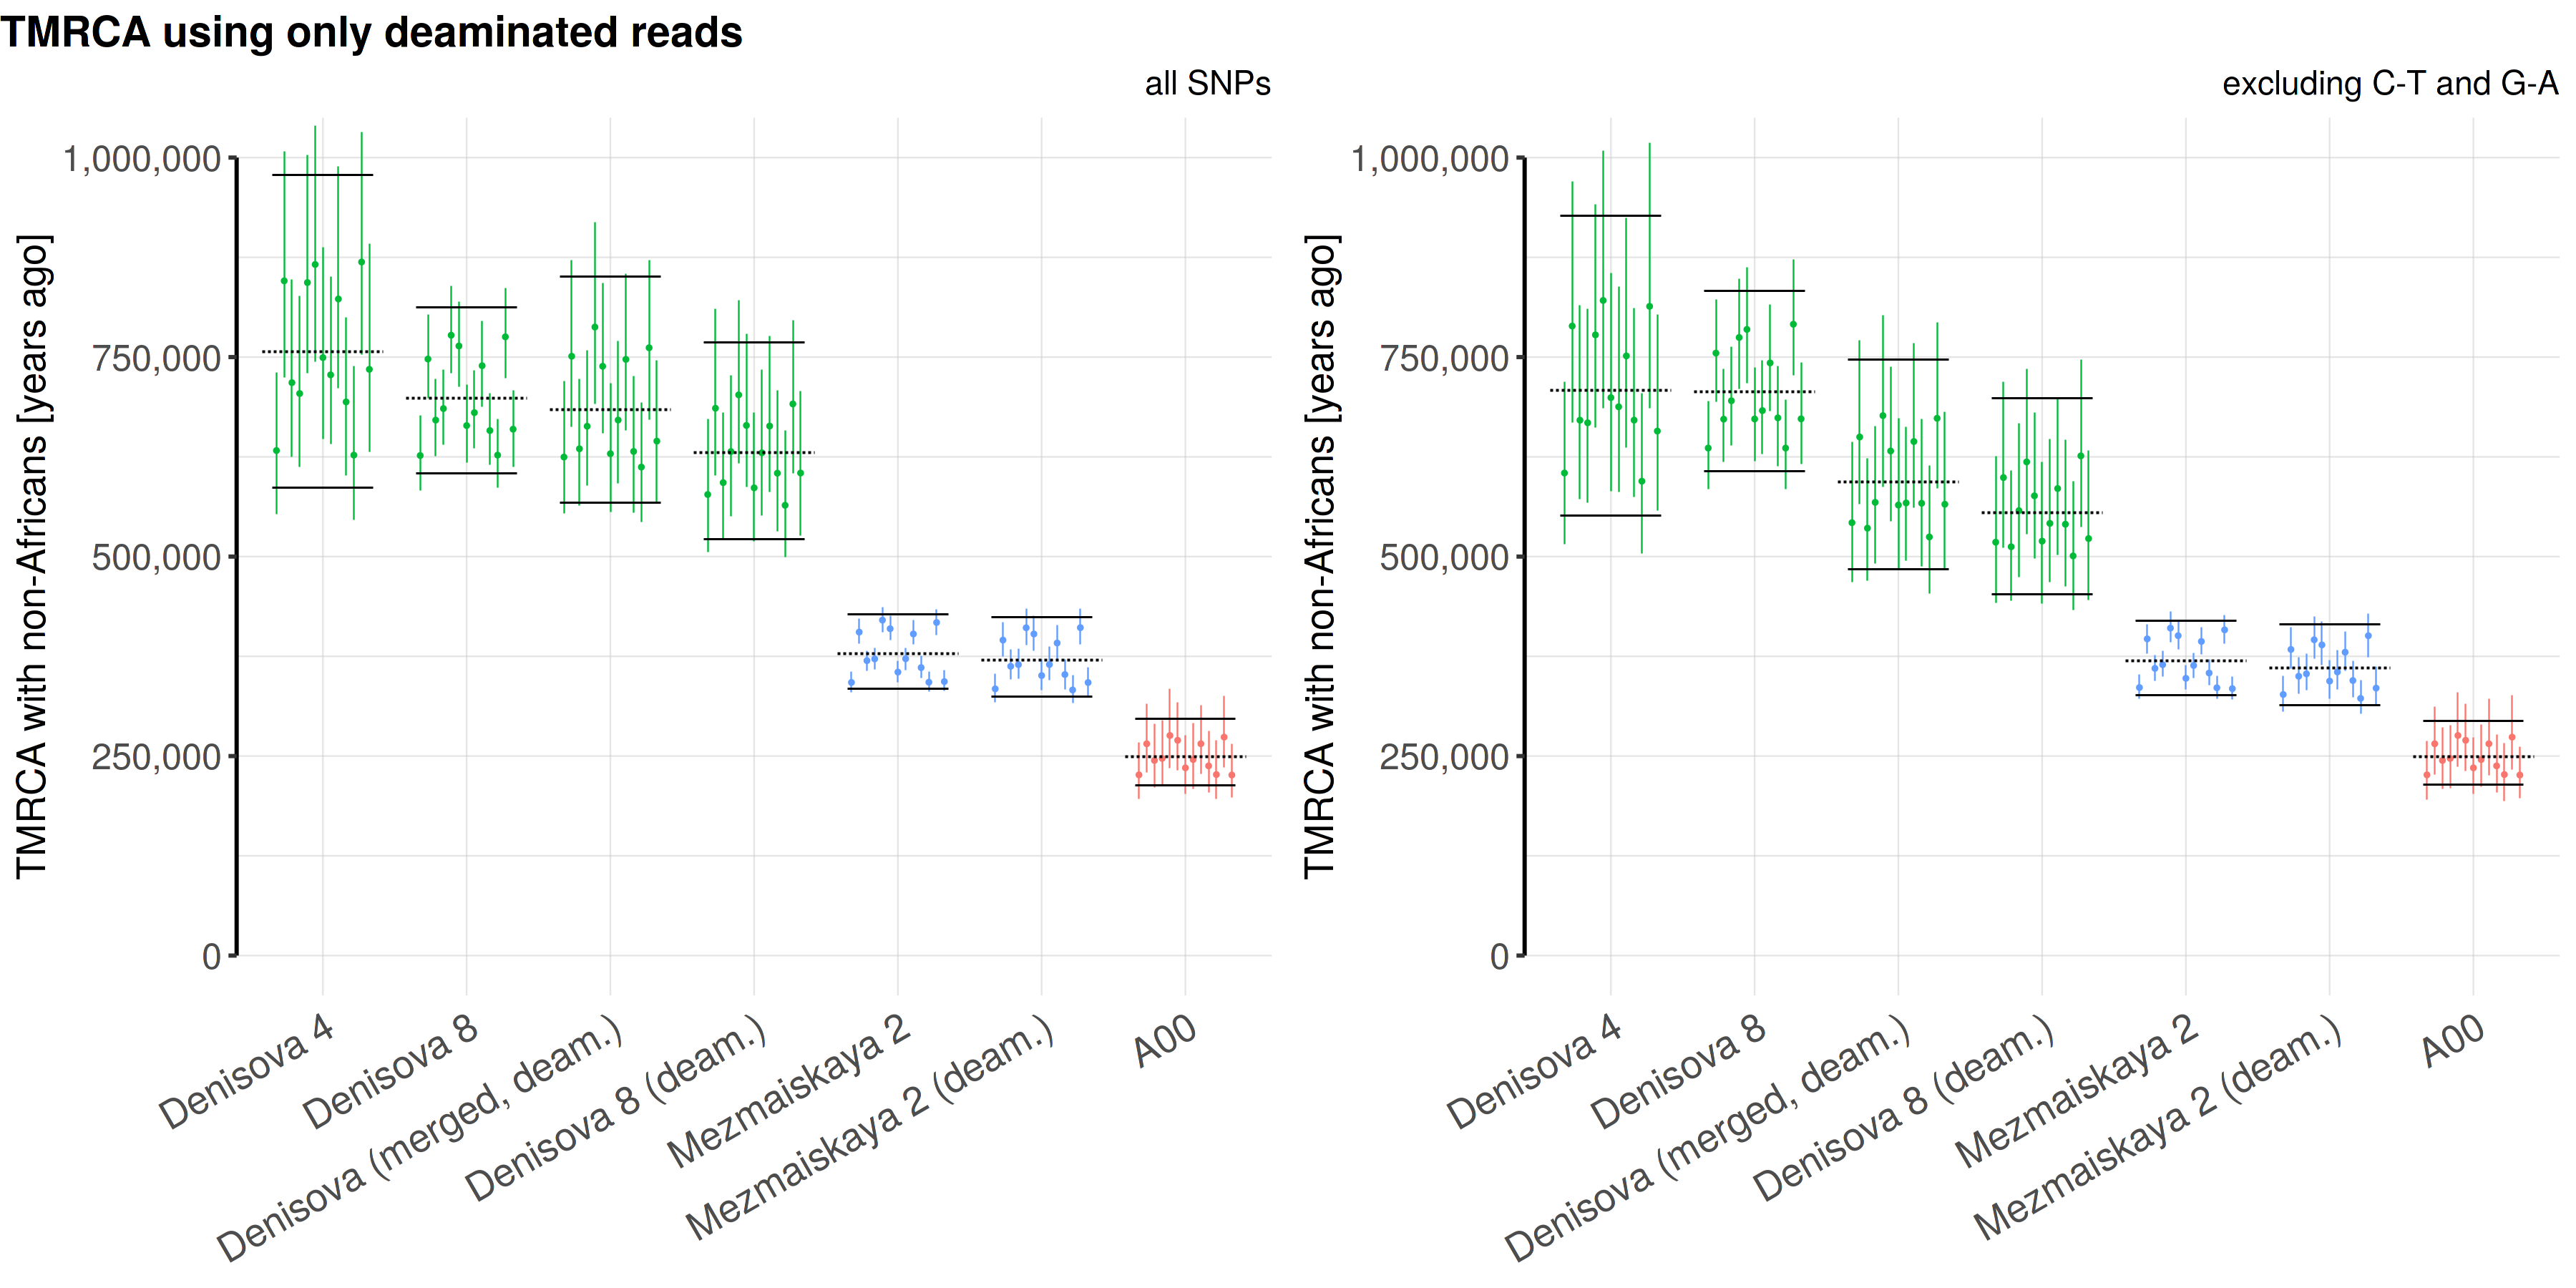

In [79]:
set_dim(12, 6)

plot_grid(p_all, p_nodmg, labels = c("TMRCA using only deaminated reads"), hjust = "left")